In [1]:
import tarfile
import pickle
import numpy as np
import os

In [4]:
# Crear un directorio temporal para extraer los archivos
extract_path = '/content/data'
os.makedirs(extract_path, exist_ok=True)

# Descomprimir el archivo
with tarfile.open('/content/cifar-10-python.tar.gz', 'r:gz') as tar:
    tar.extractall(path=extract_path)

In [6]:
def load_cifar10_batch(file):
    with open(file, 'rb') as f:
        datadict = pickle.load(f, encoding='latin1')
        X = datadict['data']
        Y = datadict['labels']
        X = X.reshape(10000, 3, 32, 32).transpose(0, 2, 3, 1).astype('float')
        Y = np.array(Y)
        return X, Y

In [7]:

# Cargar todos los lotes de entrenamiento
X_train = []
y_train = []
for i in range(1, 6):
    X, Y = load_cifar10_batch(f'/content/data/cifar-10-batches-py/data_batch_{i}')
    X_train.append(X)
    y_train.append(Y)

X_train = np.concatenate(X_train)
y_train = np.concatenate(y_train)

# Cargar el lote de prueba
X_test, y_test = load_cifar10_batch('/content/data/cifar-10-batches-py/test_batch')

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (50000, 32, 32, 3), Test shape: (10000, 32, 32, 3)


In [8]:
from tensorflow.keras.utils import to_categorical

# Normalización de imágenes
X_train = X_train / 255.0
X_test = X_test / 255.0

# Codificación one-hot de las etiquetas
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)


In [9]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Reshape, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

input_layer = Input(shape=(32, 32, 3))

# Capas CNN
x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.3)(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.3)(x)

x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.3)(x)

# Aplanamiento y transformación para LSTM
x = Flatten()(x)
x = Reshape((256, -1))(x)
x = LSTM(128, return_sequences=False, dropout=0.3, recurrent_dropout=0.3)(x)

# Capa de salida
output_layer = Dense(10, activation='softmax')(x)

# Creación del modelo
model = Model(inputs=input_layer, outputs=output_layer)
model.summary()

# Compilación del modelo
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Entrenamiento del modelo con Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 batch_normalization (Batch  (None, 32, 32, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       73856 

KeyboardInterrupt: 

In [20]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/10
782/782 [==============================] - 13s 10ms/step - loss: 1.7736 - accuracy: 0.3322 - val_loss: 1.6052 - val_accuracy: 0.3959
Epoch 2/10
782/782 [==============================] - 7s 8ms/step - loss: 1.4911 - accuracy: 0.4468 - val_loss: 1.4705 - val_accuracy: 0.4565
Epoch 3/10
782/782 [==============================] - 6s 7ms/step - loss: 1.3404 - accuracy: 0.5108 - val_loss: 1.3245 - val_accuracy: 0.5146
Epoch 4/10
782/782 [==============================] - 6s 8ms/step - loss: 1.2347 - accuracy: 0.5516 - val_loss: 1.2308 - val_accuracy: 0.5529
Epoch 5/10
782/782 [==============================] - 6s 7ms/step - loss: 1.1377 - accuracy: 0.5907 - val_loss: 1.1103 - val_accuracy: 0.5952
Epoch 6/10
782/782 [==============================] - 6s 8ms/step - loss: 1.0637 - accuracy: 0.6162 - val_loss: 1.0574 - val_accuracy: 0.6141
Epoch 7/10
782/782 [==============================] - 6s 8ms/step - loss: 1.0055 - accuracy: 0.6381 - val_loss: 0.9992 - val_accuracy: 0.6460
Epoc

In [10]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc}")

313/313 - 21s - loss: 0.9622 - accuracy: 0.6750 - 21s/epoch - 68ms/step
Test accuracy: 0.675000011920929


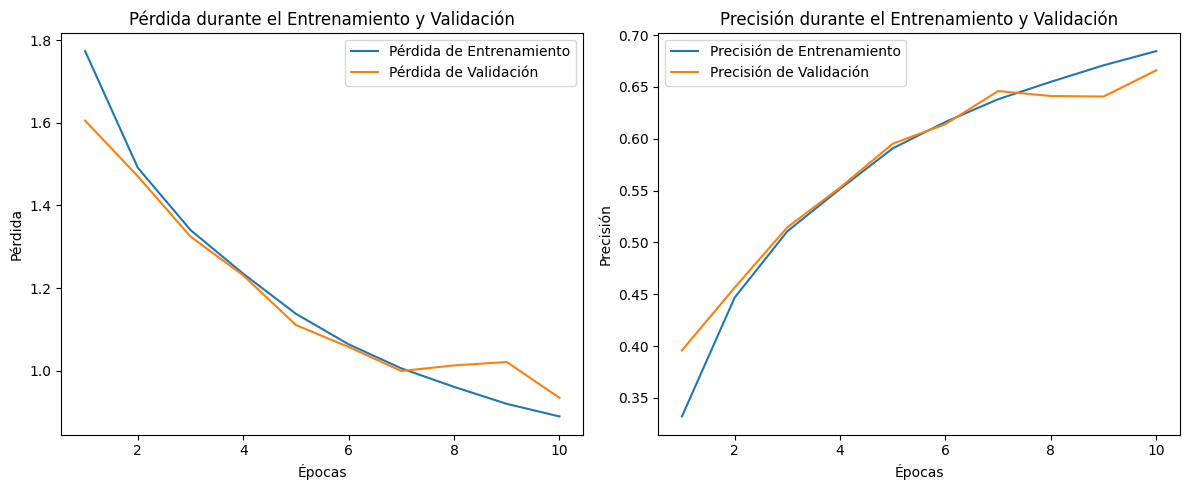

In [11]:
import matplotlib.pyplot as plt

# Datos de precisión y pérdida
epochs = list(range(1, 11))
train_loss = [1.7736, 1.4911, 1.3404, 1.2347, 1.1377, 1.0637, 1.0055, 0.9607, 0.9196, 0.8891]
val_loss = [1.6052, 1.4705, 1.3245, 1.2308, 1.1103, 1.0574, 0.9992, 1.0127, 1.0209, 0.9342]
train_accuracy = [0.3322, 0.4468, 0.5108, 0.5516, 0.5907, 0.6162, 0.6381, 0.6549, 0.6708, 0.6845]
val_accuracy = [0.3959, 0.4565, 0.5146, 0.5529, 0.5952, 0.6141, 0.6460, 0.6412, 0.6407, 0.6660]

# Gráfico de pérdida
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Pérdida de Entrenamiento')
plt.plot(epochs, val_loss, label='Pérdida de Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Pérdida durante el Entrenamiento y Validación')
plt.legend()

# Gráfico de precisión
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, label='Precisión de Entrenamiento')
plt.plot(epochs, val_accuracy, label='Precisión de Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.title('Precisión durante el Entrenamiento y Validación')
plt.legend()

plt.tight_layout()
plt.show()
